In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'
data_extraction_path = '/media/usr/HDD/Data/NAVER_df'

sids_all = []
eventID_all = []

for partition in partition_list:
    try: 
        eventID_list = [filename.split('.')[0] for filename in os.listdir(os.path.join(data_path, 'networks', partition)) if filename[0] != '.']
        eventID_list = np.unique(eventID_list)
        eventID_all.append(eventID_list)

        for eventID in eventID_list:
            with open(os.path.join(data_path, 'networks', partition, '{}.pickle'.format(eventID)), 'rb') as f:
                accident_info = pickle.load(f)
            G = nx.read_gpickle(os.path.join(data_path, 'networks', partition, '{}.gpickle'.format(eventID)))

            sids_all.append(accident_info[1])
            sids_all.append(accident_info[2])
    except:
        continue

eventID_all = [x for y in eventID_all for x in y]
eventID_all = np.unique(eventID_all)
        
sids_all = [x for y in sids_all for x in y]
sids_all = np.unique(sids_all)

print('# of all Events, # of sids = ', len(eventID_all), len(sids_all))

# of all Events, # of sids =  4203 15629


In [4]:
# # Profile Extraction Functions
# def profile_extraction2(speed_all):
#     # Day of Week => monday : 0, sunday : 6
#     speed_all['weekday'] = [s.weekday() for s in speed_all.index]
#     speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
#     profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
#     profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
#     speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
#     return speed_all, profile_mean, profile_std

## Data Loading

In [5]:
## load accident_all
accident_all = pd.read_csv('data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of filtered Events =  849


In [6]:
accident_all['accident_sid'].value_counts()

1210005301    20
1030001902    19
1220005401    15
1210003000    13
1130052300    12
              ..
2210066900     1
1120013402     1
1100005401     1
1070010402     1
1040020100     1
Name: accident_sid, Length: 482, dtype: int64

In [7]:
    target_sid = 1210005301 ## 1030001902    ## 1210005301
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
    eventID = accident_case.eventId.iloc[0]
    normalize = 'standard'

    eventID = str(eventID)

    # accident info : 0 : description / 1 : sid / 2 : sid 
    # what sids?
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    G = nx.read_gpickle(os.path.join(data_path, 'speeds', eventID, '{}.gpickle'.format(eventID)))

    sid_list = accident_info[1] + accident_info[2]

    accident_sid = accident_info[0]['sids'][0]
    accident_created = accident_info[0]['created']

    # feature extraction
    with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
        test = pickle.load(f)
    speed_inflow = test['speed_inflow']
    speed_outflow = test['speed_outflow']

    speed_all = pd.concat([speed_inflow, speed_outflow], axis=1)
    speed_all = speed_all.dropna(axis=1, how='all')
    
    tmp = speed_all[accident_sid].iloc[:, 0].values
    speed_all = speed_all.drop([accident_sid], axis=1)
    speed_all[accident_sid] = tmp

    ## selected nodes
    sid_list = list(set(list(speed_inflow.columns) + list(speed_outflow.columns) + [accident_sid]))
    H = nx.subgraph(G, sid_list)

    ## speed_all 5min rolling & normalize
    speed_all = speed_all.resample(rule='5T').mean()
    if normalize == 'standard':
        scaler = StandardScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'minmax':
        scaler = MinMaxScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'profile':
        ## profile extraction
        # profile_all = profile_extraction(df_all_norm)
        speed_all, profile_mean, profile_std = profile_extraction2(speed_all)

        ## profile normalization
        date_index = np.arange(datetime(2020, 9, 2), datetime(2021, 3, 1), timedelta(days=1)).astype(datetime)
        df_all_norm = speed_all.copy()

        for date in date_index:
            date_index = np.arange(date, date+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
            tmp = speed_all.loc[date_index]
            weekday = date.weekday()
            mean_tmp = profile_mean[288*weekday:288*(weekday+1)]
            std_tmp = profile_std[288*weekday:288*(weekday+1)]

            normalized = (tmp.values - mean_tmp) / std_tmp
            df_all_norm.loc[date_index] = normalized.values

#         df_all_norm = df_all_norm.rolling(3).mean()

#     # define anomaly label
#     labels = []
#     accident_case['created'] = pd.to_datetime(accident_case['created'])
#     for ix, row in accident_case.iterrows():
#         accident_created = row['created']
#         min = accident_created.minute % 5
#         sec = accident_created.second
#         accident_pt = accident_created - timedelta(minutes=min, seconds=sec)
#         labels.append(list(map(int, (df_all_norm.index >= accident_pt+timedelta(minutes=-60)) & (df_all_norm.index < accident_pt+timedelta(minutes=60)))))
#     labels = list(map(int, (np.sum(labels, axis=0) > 0)))
#     label_df = pd.DataFrame(labels, index=df_all_norm.index, columns=['label'])

In [8]:
# from datasets.Myloader import profile_loader
# train_loader, val_loader, test_loader = profile_loader(df_all_norm, label_df, H)
# len(train_loader), len(val_loader), len(test_loader)

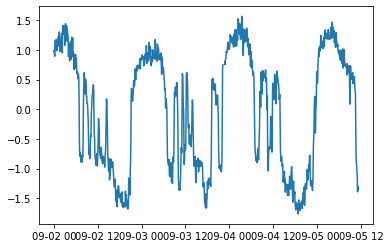

In [9]:
plt.plot(df_all_norm[:1000][accident_sid])

In [10]:
df_all_norm[:1000][accident_sid].isna().sum()

5

## Recurrent Label

In [11]:
label_df = pd.DataFrame(0, index=df_all_norm.index, columns=['label'])


In [12]:
recurrent_label = np.zeros(label_df.shape)
t0 = 76
t1 = 105
for i in range(len(label_df) // 288):
    date = df_all_norm.index[t0+288*i]
    if date.weekday() <= 4:
        recurrent_label[t0+288*i:t1+288*i] = 1
# recurrent_label = recurrent_label[24:]

In [13]:
date = df_all_norm.index[t0]
date.weekday()

2

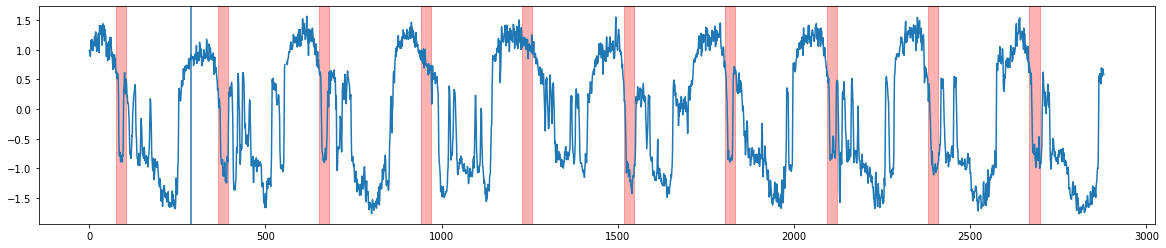

In [14]:
plt.figure(figsize=(20, 4))
plt.plot(df_all_norm.iloc[:288*10][target_sid].values)
plt.axvline(288)
t0 = 76
t1 = 105
for i in range(10):
    plt.axvspan(t0+288*i, t1+288*i, color='r', alpha=0.3)

In [15]:
target_sid = 1210005301
with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
    test = pickle.load(f)
path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    df_agg_inflow.append(df_all_norm[inflow].mean(axis=1))
    df_agg_outflow.append(df_all_norm[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

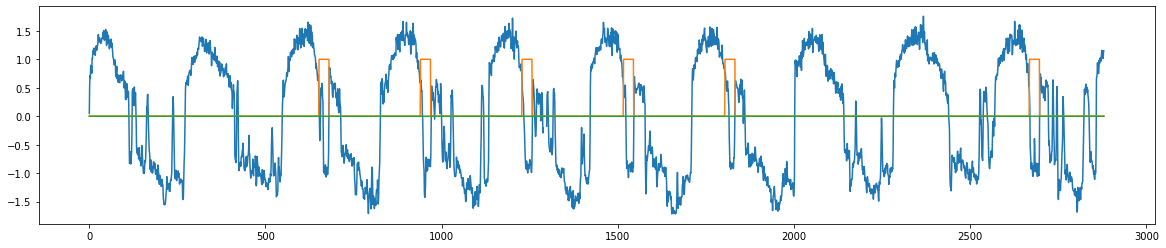

In [16]:
plt.figure(figsize=(20, 4))
plt.plot(df_all_norm.iloc[288*80:288*90][target_sid].values)
# for i in range(15):
#     plt.axvspan(t0+288*i, t1+288*i, color='r', alpha=0.3)
plt.plot(recurrent_label[288*80:288*90])
plt.plot(label_df[288*80:288*90].values)

In [17]:
label_df.iloc[np.where(recurrent_label == 1)[0]] = 1

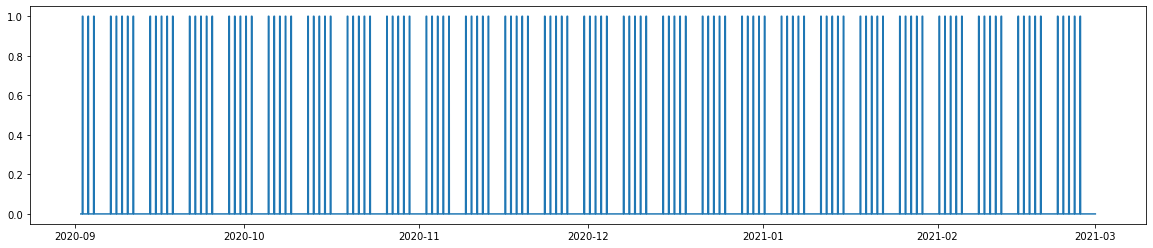

In [18]:
plt.figure(figsize=(20, 4))
plt.plot(label_df)

## Congestion Label 수정

In [19]:
plot=True

/tmp/ipykernel_1111813/2649541526.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_case['created'] = pd.to_datetime(accident_case['created'])


!!!
!!!
!!!


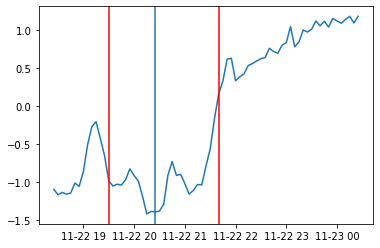

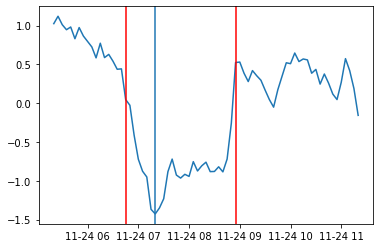

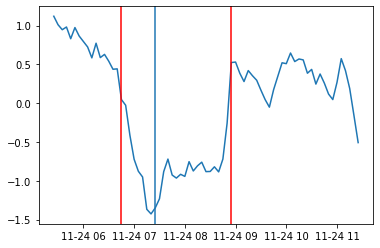

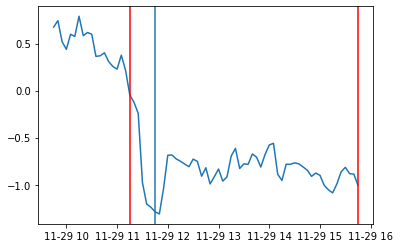

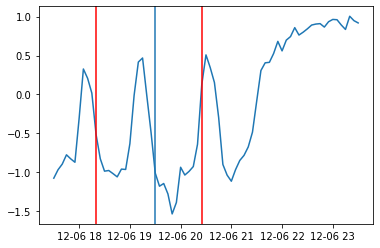

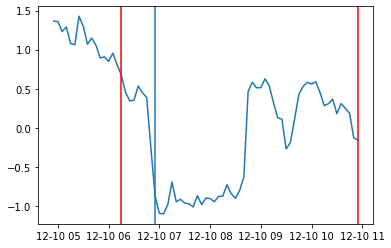

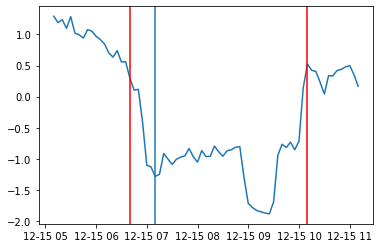

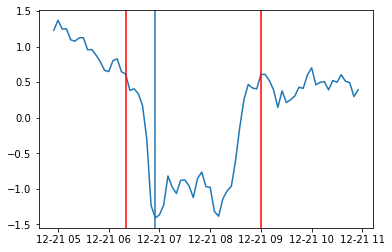

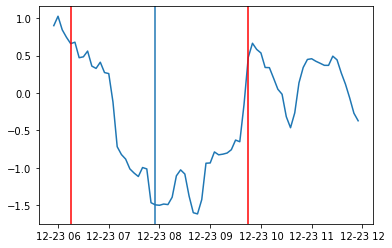

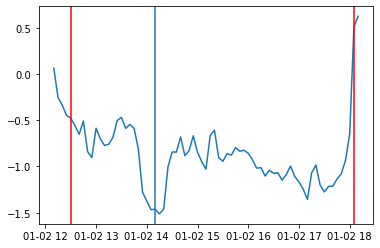

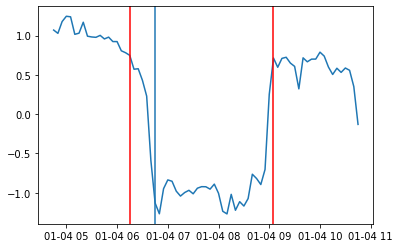

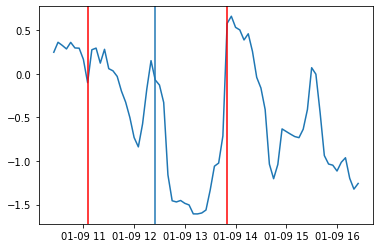

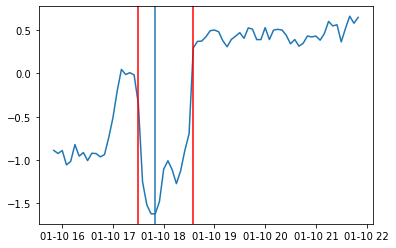

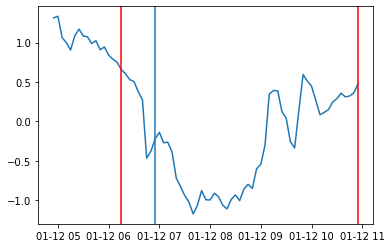

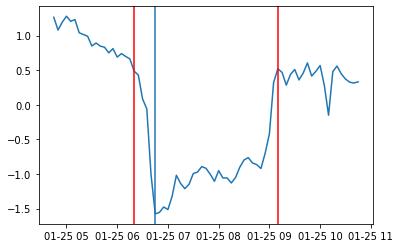

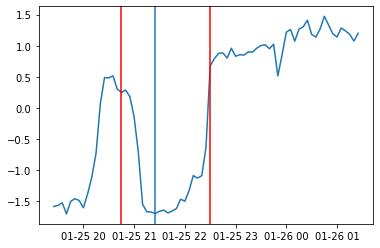

In [20]:
# label_df = pd.DataFrame(0, index=df_all_norm.index, columns=['label'])
cnt = 0

## Incident Data Plot
accident_case['created'] = pd.to_datetime(accident_case['created'])
for ix, row in accident_case.iterrows():
    t = row['created']
    accident_sid = row['accident_sid']
#     if (t.month != 1) and (t.month != 12):
#         continue
    if (t.month == 2):
        continue

    
    eventID = str(row['eventId'])
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
        
    accident_dt = accident_info[0]['created'].to_pydatetime()
    accident_dt = datetime.fromtimestamp(round(accident_dt.timestamp()/300)*300)
    accident_idx = np.where(df_all_norm.index == accident_dt)[0][0]
    df_pre = df_all_norm[accident_dt - timedelta(minutes=120):accident_dt]
    if df_pre.mean()[accident_sid] > 0:
        df_start_condition = (df_pre.mean() > df_all_norm)[accident_sid]
    else:
        df_start_condition = (df_pre.quantile(0.8) > df_all_norm)[accident_sid]
    df_start_condition = df_start_condition.astype(int).diff()==1
    
    congestion_start_list = np.where(df_start_condition==True)[0]
    congestion_start_list = np.unique([idx for idx in congestion_start_list if (accident_idx - 12*2 <= idx) & (idx <= accident_idx)])
    if len(congestion_start_list) == 0:
        congestion_start_time = accident_dt
    else:
        congestion_start_time = df_all_norm.index[congestion_start_list[0]].to_pydatetime()

#     df_end_condition = (df_pre.mean() < df_all_norm)[accident_sid]
#     congestion_end_list = np.where(df_end_condition==True)[0]
#     congestion_end_list = np.unique([idx for idx in congestion_end_list if (accident_idx - 12*2 <= idx) & (idx <= accident_idx)])
    
    df_avg_pre_new = df_all_norm[congestion_start_time - timedelta(minutes=60):accident_dt]
    zero_condition = pd.DataFrame(0, index=df_avg_pre_new.index, columns=df_avg_pre_new.columns)
    df_end_condition = (np.maximum(zero_condition.mean(), df_avg_pre_new.mean()) < df_all_norm)[accident_sid]
    df_end_condition = df_end_condition.astype(int).diff()==1
    congestion_end_list = np.where(df_end_condition==True)[0]
    congestion_end_list = [idx for idx in congestion_end_list if (accident_idx <= idx) & (idx <= accident_idx + 12*4)]
    if len(congestion_end_list) == 0:
        print("!!!")
        congestion_end_list = [accident_idx+12*4]
    congestion_end_time = df_all_norm.index[congestion_end_list[0]].to_pydatetime()

#     congestion_start_time, congestion_end_time, _ = get_congestion_start_end(df_avg, accident_info, std_min=30, start_period=12*2, end_period=12*24, gap=120/5)
    if plot==True:
        plt.figure()
        plt.plot(df_all_norm[accident_dt+timedelta(minutes=-120) :accident_dt+timedelta(minutes=240)][target_sid])
        plt.axvline(congestion_start_time, color='red')
        plt.axvline(congestion_end_time, color='red')
        plt.axvline(accident_dt)
        
    cnt += 1
    ## Label generation
    label_df[congestion_start_time:congestion_end_time] = 2

    

label    4641
dtype: int64

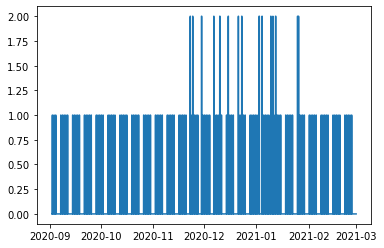

In [21]:
plt.plot(label_df)
label_df.sum()

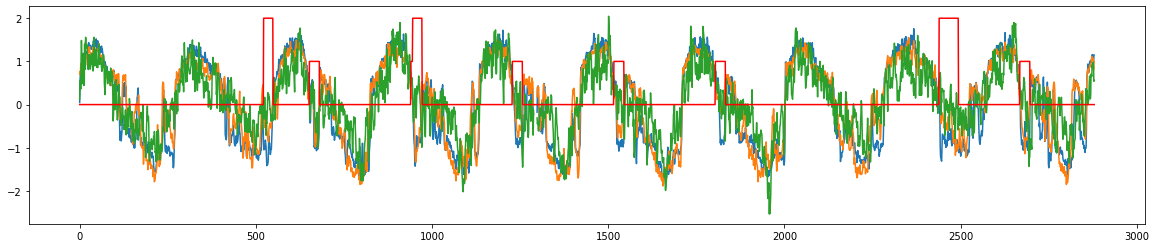

In [22]:
plt.figure(figsize=(20, 4))
plt.plot(df_all_norm.iloc[288*80:288*90][target_sid].values)
plt.plot(df_agg_inflow.iloc[288*80:288*90][1].values)
plt.plot(df_agg_outflow.iloc[288*80:288*90][1].values)
# plt.plot(recurrent_label[288*80:288*90], color='k')
plt.plot(label_df[288*80:288*90].values, color='r')

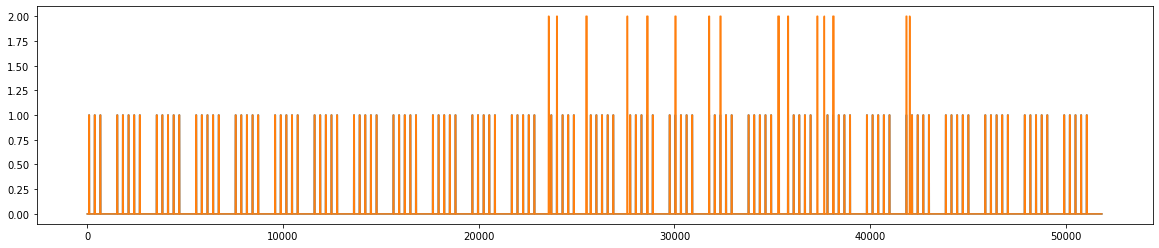

In [23]:
plt.figure(figsize=(20, 4))
plt.plot(recurrent_label)
plt.plot(label_df.values)

## Speed Data Preprocessing

### Scaling

In [24]:
from sklearn.preprocessing import RobustScaler

In [25]:
## Scaling
sc = RobustScaler()
transform = sc.fit_transform(df_all_norm)
df_all_norm = pd.DataFrame(transform, index=df_all_norm.index, columns=df_all_norm.columns)

In [26]:
rolling_window = 3
df_all_norm = df_all_norm.rolling(rolling_window).mean()
df_all_norm = df_all_norm.iloc[rolling_window-1:]

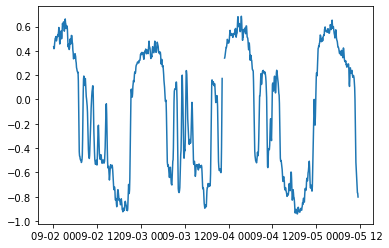

In [27]:
plt.plot(df_all_norm[:1000][accident_sid])

### NaN values 

In [28]:
train_df = df_all_norm[df_all_norm.index < datetime(2020, 12, 1)]
val_df = df_all_norm[(df_all_norm.index >= datetime(2020, 12, 1)) & (df_all_norm.index < datetime(2021, 1, 1))]
test_df = df_all_norm[(df_all_norm.index >= datetime(2021, 1, 1)) & (df_all_norm.index < datetime(2021, 2, 1))]

In [29]:
train_df.shape, test_df.shape

((25918, 26), (8928, 26))

In [30]:
train_df = train_df.bfill(limit=36).ffill(limit=36).fillna(0, limit=288).dropna(axis=1)
val_df = val_df.bfill(limit=36).ffill(limit=36).fillna(0, limit=288).dropna(axis=1)
test_df = test_df.bfill(limit=36).ffill(limit=36).fillna(0, limit=288).dropna(axis=1)

In [31]:
train_df.shape, test_df.shape

((25918, 25), (8928, 25))

## Sensor Graph

In [32]:
len(H.nodes)

26

In [33]:
sid_list = list(map(int, train_df.columns))

In [34]:
H = nx.subgraph(H, sid_list)
len(H.nodes)

25

### Save

In [35]:
dataset = '{}_3class'.format(target_sid)

In [36]:
os.makedirs('data/{}'.format(dataset), exist_ok=True)

In [37]:
train_df.to_csv('data/{}/train_x.csv'.format(dataset))
val_df.to_csv('data/{}/val_x.csv'.format(dataset))
test_df.to_csv('data/{}/test_x.csv'.format(dataset))

In [38]:
label_df = label_df.iloc[rolling_window-1:]
label_df.to_csv('data/{}/labels.csv'.format(dataset))

In [39]:
train_label = label_df[label_df.index < datetime(2020, 12, 1)]
val_label = label_df[(label_df.index >= datetime(2020, 12, 1)) & (label_df.index < datetime(2021, 1, 1))]
test_label = label_df[(label_df.index >= datetime(2021, 1, 1)) & (label_df.index < datetime(2021, 2, 1))]

In [40]:
train_label.to_csv('data/{}/train_y.csv'.format(dataset))
val_label.to_csv('data/{}/val_y.csv'.format(dataset))
test_label.to_csv('data/{}/test_y.csv'.format(dataset))

In [41]:
## network graph
nx.write_gpickle(H.copy(), "data/{}/sensor_graph.gpickle".format(dataset))

In [43]:
test_label.value_counts()

label
0        8141
1         522
2         265
dtype: int64

In [46]:
265 / (522+265)

0.33672172808132145

In [44]:
train_label.value_counts()

label
0        23977
1         1832
2          109
dtype: int64

In [47]:
109 / (1832+109)

0.056156620298815046